## Install the package dependencies before running this notebook

In [1]:
import torch
import os, os.path 
import pickle
from glob import glob
import pandas as pd
import numpy as np 
import random
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.optim import Rprop, Adam
import math
import time
torch.set_default_dtype(torch.float)
"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.cuda.is_available()

True

## Create a Torch.Dataset class for the training dataset

In [2]:
ROOT_PATH = ""
#ROOT_PATH = "./argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    f_in = ROOT_PATH + split + "/" + city + "_inputs"
    inputs = pickle.load(open(f_in, "rb"))
    inputs = np.asarray(inputs)
    
    #outputs = None
    outputs = np.zeros((inputs.shape[0], 60, 2))
    
    if split=="train":
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)
        
          

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

# intialize a dataset
city = 'palo-alto'
#city = 'washington-dc' 
split = 'test'
train_dataset  = ArgoverseDataset(city = city, split = split)
inpu , out = train_dataset[0]


## Create a DataLoader class for training

batch_sz = 4 # batch size 
train_loader = DataLoader(train_dataset,batch_size=batch_sz)

## Sample a batch of data and visualize 

import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
   
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1], alpha=0.5)
        axs[i].scatter(out[i,:,0], out[i,:,1], alpha=0.2)

        
for i_batch, sample_batch in enumerate(train_loader):
    inp, out = sample_batch
    
    """
    TODO:
      implement your Deep learning model
      implement training routine
    """
    
    show_sample_batch(sample_batch)
    break

In [3]:
#feature engineering
# Calculate the distance between two points
def calc_distance(a, b):
    return math.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

# Calculate the velocity between two points
def velocity(a,b):
    return [(b[0] - a[0])/0.1, (b[1] - a[1]/0.1) ]

def speed(a,b):
    dist = math.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)
    return dist/0.1
# encoder city
def onehot_city(city):
    if city == "austin":
        return [1,0,0,0,0,0]
    elif city == "miami":
        return [0,1,0,0,0,0]
    elif city == "pittsburgh":
        return [0,0,1,0,0,0]
    elif city == "dearborn":
        return [0,0,0,1,0,0]
    elif city == "washington-dc":
        return [0,0,0,0,1,0]
    else:
        return [0,0,0,0,0,1]    

In [40]:
#get tensor x
def get_input_tensor(cities_dataset, split, val = False):
    X = []
    for city in cities_dataset:
        #print("input x: " + "Processing city", city)
        dataset = ArgoverseDataset(city = city, split = split)
        for i in range(cities_dataset[city]):
            
            if val is True:
                i+= cities_dataset[city]
            # city feature  
            x1 = onehot_city(city)
            X.extend(x1)
            
            # coordinate feature
            inpu, _ = dataset[i]            
            
            # Record start/end position/velocity of the target car 
            end_pos_x = inpu[49][0]
            end_pos_y = inpu[49][1]
            
            for j in range(inpu.shape[0]):
                if j == 0:
                    vel_x , vel_y = velocity(inpu[j], inpu[j])
                    dist = calc_distance(inpu[j], inpu[j])
                else:
                    vel_x , vel_y = velocity(inpu[j-1], inpu[j])
                    dist = calc_distance(inpu[j-1], inpu[j])
                pos_x = inpu[j][0] -  end_pos_x
                pos_y = inpu[j][1] -  end_pos_y
                X.append(pos_x)
                X.append(pos_y)
#                 X.append(vel_x)
#                 X.append(vel_y)
#                 X.append(dist)

            
            feat_num_in =  len(x1)+ 100 #+ 100 + 50#len(x2)#+ len(x3) + len(x4) +  
            
    tensor_x = torch.tensor(X).reshape(sum(cities_dataset.values()), feat_num_in)  
    return tensor_x

#get tensor y 
def get_out_tensor(cities_dataset, split, val = False):
    Y = []
    feat_num_out = 120
    for city in cities_dataset:
        
        dataset = ArgoverseDataset(city = city, split = split)
        
        for i in range(cities_dataset[city]):
            if val is True:
                i+= cities_dataset[city]
            # coordinate feature
            inpu, out = dataset[i]
            end_pos_x = inpu[49][0]
            end_pos_y = inpu[49][1]
            
            for j in range(out.shape[0]):
                pos_x = out[j][0] -  end_pos_x
                pos_y = out[j][1] -  end_pos_y
                Y.append(pos_x)
                Y.append(pos_y)
               
            
            #y = list(out.reshape(120))
            #Y.extend(y)
    
    tensor_y = torch.tensor(Y).reshape(sum(cities_dataset.values()), feat_num_out)
    return tensor_y
            

In [41]:
cities_train = {"austin":40000, 
               "miami":50000, 
                "pittsburgh":40000, 
                "dearborn":22000, 
                "washington-dc":23000, 
                "palo-alto":11000}
# train dataset
#cities_train = city_data('miami')
train_tensor_x = get_input_tensor(cities_train, "train").to(device)
train_tensor_y = get_out_tensor(cities_train, "train").to(device)
# train_dataset = TensorDataset(train_tensor_x,train_tensor_y)

In [ ]:
class SequenceDataset(Dataset):
    def __init__(self,features, target, sequence_length=50):
        self.sequence_length = sequence_length
        self.y = target
        self.X = features

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [43]:
train_dataset = SequenceDataset(
    train_tensor_x,
    train_tensor_y,
)

In [44]:
cities_val = {"austin":3041, 
               "miami":5029, 
                "pittsburgh":3544, 
                "dearborn":2465, 
                "washington-dc":2744, 
                "palo-alto":993}

# validation dataset 
val_tensor_x  = get_input_tensor(cities_val, "train", val = True).to(device)
val_tensor_y = get_out_tensor(cities_val, "train", val = True).to(device)
# val_dataset = TensorDataset(val_tensor_x, val_tensor_y)
# val_dataloader = DataLoader(val_dataset, batch_size = 2000)

In [45]:
val_dataset = SequenceDataset(
    val_tensor_x,
    val_tensor_y,
)
val_dataloader = DataLoader(val_dataset, batch_size = 2000)

### Build, Train model and Evaluate 

In [ ]:
# class Model(nn.Module):
#     def __init__(self):
#         super(Model, self).__init__()
#         self.hidden_dim = 100
#         self.layer_dim = 3
#         self.input_dim = 156
#         self.output_dim = 120

#         # LSTM layers
#         self.lstm = nn.LSTM(
#             self.input_dim, self.hidden_dim, self.layer_dim, batch_first=True, dropout=0.2
#         )
#         self.fc1 = nn.Linear(in_features = hidden_dim, out_features = int(hidden_dim / 2))
#         self.act1 = nn.ReLU(inplace = True)
#         self.bn1 = nn.BatchNorm1d(num_features = int(hidden_dim / 2))

#         self.estimator = nn.Linear(in_features = int(hidden_dim / 2), out_features = 1)
    

#         # Fully connected layer
#         self.fc = nn.Linear(self.hidden_dim, self.output_dim)

#     def forward(self, x):
#         h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda().requires_grad_()
#         c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda().requires_grad_()
#         out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
#         out = out[:, -1, :]

#         # Convert the final state to our desired output shape (batch_size, output_dim)
#         out = self.fc(out)

#         return x

In [79]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_dim = 256
        self.layer_dim = 1
        self.input_dim = 106#256
        self.output_dim = 120
        self.batch_size = 64

        # LSTM layers
        self.lstm = nn.LSTM(
            self.input_dim, self.hidden_dim, self.layer_dim, batch_first=True
        )
        self.fc = nn.Linear(in_features = self.hidden_dim, out_features = 4096)
        #self.act = nn.ReLU(inplace = True)
        self.act = nn.Sigmoid()
        self.fc2 = nn.Linear(4096,2048)
        self.estimator = nn.Linear(2048, 120)
    

    def init_hidden(self, size):
        return torch.zeros(self.layer_dim, size, self.hidden_dim).to(device)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.shape[0], self.hidden_dim).requires_grad_().to(device)

        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.shape[0], self.hidden_dim).requires_grad_().to(device)

        # One time step
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        #size = x.shape[0]
        #hidden_state = self.init_hidden(size)
        #cell_state = hidden_state
        
        #out, _ = self.lstm(x, (hidden_state, cell_state))

        out = out[:, -1, :]
        out = self.fc(out)
        out = self.act(out)
        out = self.fc2(out)
        out = self.estimator(out)
        
        return out


In [90]:
# Train function
def train(model, x, y, optimizer, criterion):
    optimizer.zero_grad()
    output = model(x.float())
    loss = criterion(output, y.float())
    loss.backward()
    optimizer.step()
    return loss, output

# get val loss function
def getValLoss(model, criterion):
    total_loss = 0
    batch_count = 0
    for i_batch, sample_batch in enumerate(val_dataloader):
        
        x_val, y_val = sample_batch[0], sample_batch[1]
        output = model(x_val.float())
        total_loss += criterion(output, y_val.float()).item()
        batch_count +=1
    return total_loss/batch_count

In [48]:
model = Net().to(device)
optm = Adam(model.parameters(), lr=0.0001)

#scheduler = torch.optim.lr_scheduler.MultiStepLR(optm, milestones = [10,20,40], gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optm, mode='min', factor=0.1, patience=2, eps=1e-10, verbose=True)
criterion = nn.MSELoss().to(device)


all_train_loss = []
all_val_loss = []

EPOCH_LENGTH = 150
BATCH_SIZE = 64
patience = 2
trigger_times = 0

start = time.time()
for epoch in range(EPOCH_LENGTH):
    total_loss  = 0
    batch_count = 0
    
    my_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True) 
    for i_batch, (x_train, y_train) in enumerate(my_dataloader):
        loss, _ = train(model, x_train, y_train, optm, criterion)
        total_loss += loss.item()
        batch_count += 1
    
    #calculate train loss and val loss
    train_loss = total_loss/batch_count
    val_loss = getValLoss(model, criterion)
    all_train_loss.append(train_loss)
    all_val_loss.append(val_loss)
    
    # log
#     if (epoch+1) % 10 == 0:
    print('Time{}, epoch {}, Train loss: {}, Val loss: {}'.format(timeSince(start), epoch, train_loss, val_loss))
   
    scheduler.step(train_loss)


Time0m 31s, epoch 0, Train loss: 35.07663953661058, Val loss: 24.151152928670246
Time0m 57s, epoch 1, Train loss: 23.809872219806117, Val loss: 22.812458250257706
Time1m 20s, epoch 2, Train loss: 23.340107010367976, Val loss: 25.086985694037544
Time1m 45s, epoch 3, Train loss: 22.792145972158394, Val loss: 23.124792734781902
Time2m 9s, epoch 4, Train loss: 22.408755151849043, Val loss: 22.46766471862793
Time2m 34s, epoch 5, Train loss: 22.167241942238718, Val loss: 21.461434258355034
Time2m 58s, epoch 6, Train loss: 21.938232596731694, Val loss: 20.966515858968098
Time3m 22s, epoch 7, Train loss: 21.648068568121744, Val loss: 21.157162772284615
Time3m 46s, epoch 8, Train loss: 21.447337010491538, Val loss: 21.436857011583115
Time4m 11s, epoch 9, Train loss: 21.322854933067823, Val loss: 21.026206758287216
Time4m 35s, epoch 10, Train loss: 21.126123915187755, Val loss: 20.905380884806316
Time5m 0s, epoch 11, Train loss: 21.00708479236646, Val loss: 20.886794408162434
Time5m 25s, epoch 1

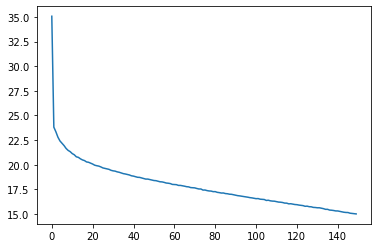

In [49]:
plt.plot(all_train_loss)

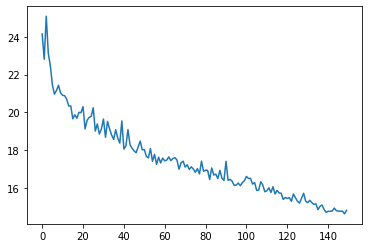

In [50]:
plt.plot(all_val_loss)

## Examining the submission format

In [51]:
sample_sub = pd.read_csv('sample_submission.csv')
sample_sub.head()

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [206]:
def city_data(city_name):
    if city_name == "austin":
        return {'austin':6325}
    elif city_name == "miami":
        return {'miami':7971}
    elif city_name == "pittsburgh":
        return {'pittsburgh': 6361}
    elif city_name == "dearborn":
        return {'dearborn':3671}
    elif city_name == "washington-dc":
        return {'washington-dc':3829}
    else:
        return {'palo-alto':1686}

num_pred_steps = 60
all_preds = np.zeros(shape=(0, num_pred_steps * 2))
city_col = np.array([])
cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]

test_data = [6325, 7971, 6361, 3671, 3829, 1686]
for city_name in cities:

    inpu, out = get_city_trajectories(city=city_name, split="test")
    all_end_pos_x = []
    all_end_pos_y = []
    for i in inpu:
        end_pos_x = i[49][0]
        end_pos_y = i[49][1]
        all_end_pos_x.append(end_pos_x)
        all_end_pos_y.append(end_pos_y)
    city_test = city_data(city_name)
    test_x = get_input_tensor(city_test, "test")
    test_loader = DataLoader(SequenceDataset(test_x.to(device), torch.tensor(np.zeros((test_x.shape[0],120)))))
    
    outcome = []
    model.eval()
    with torch.no_grad():
        for sample_batch in test_loader:
            x_test = sample_batch[0]
            
            output = model(x_test.float()).cpu().detach().numpy()
            outcome.append(output)
        
    #outcome = model(test_loader)
    
    test_pred_arr = np.array(outcome)
    test_pred_arr_reshaped = np.reshape(test_pred_arr, newshape=(test_x.shape[0], num_pred_steps * 2))
    for i in range(test_pred_arr_reshaped.shape[0]):
        for j in range(60):
        
            test_pred_arr_reshaped[i][j*2] = test_pred_arr_reshaped[i][j*2] + all_end_pos_x[i]
            test_pred_arr_reshaped[i][j*2+1] = test_pred_arr_reshaped[i][j*2+1] + all_end_pos_y[i]
    
    #test_pred_arr_reshaped = np.reshape(test_pred_arr, newshape=(test_x.shape[0], num_pred_steps * 2))
    
    all_preds = np.r_[all_preds, test_pred_arr_reshaped]
    
    city_col = np.r_[city_col, [str(i) + "_" + city_name for i in range(test_pred_arr.shape[0])]]


In [207]:
sub_df = pd.DataFrame(np.c_[city_col, all_preds], columns=[np.r_[["ID"], ["v" + str(i) for i in range(120)]]])
sub_df.to_csv('test_sub_2.csv', index=None)

In [208]:
test_sub = pd.read_csv('test_sub_2.csv')
test_sub.head()

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,-13.103030,-566.904053,-14.465156,-566.223511,-16.038363,-565.575745,-17.578993,-565.082947,-19.039581,...,-99.631897,-536.512512,-101.038956,-536.040344,-102.273689,-535.657349,-103.311226,-535.302612,-104.152504,-535.019165
1,1_austin,-344.724487,11.986337,-344.227417,11.659631,-343.600952,11.330400,-342.993744,11.096383,-342.416870,...,-302.780487,-7.724325,-302.132538,-8.195616,-301.574524,-8.621778,-301.097076,-8.957762,-300.714539,-9.248537
2,2_austin,50.982666,-247.707520,50.974007,-247.750214,50.965851,-247.802612,50.953869,-247.850647,50.951221,...,49.641914,-248.418304,49.597363,-248.392044,49.559330,-248.367859,49.528313,-248.344940,49.503227,-248.328949
3,3_austin,-113.809677,1798.274536,-113.814751,1798.389526,-113.819565,1798.508789,-113.826157,1798.614502,-113.827621,...,-116.250610,1802.670410,-116.313576,1802.730225,-116.372261,1802.775391,-116.416260,1802.816284,-116.454857,1802.849365
4,4_austin,1195.851440,-638.044189,1196.960083,-638.599121,1198.214966,-639.148926,1199.436646,-639.576477,1200.591309,...,1260.153809,-667.780029,1261.119263,-668.238159,1261.958252,-668.641785,1262.666748,-668.979187,1263.241089,-669.251831


In [150]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [177]:
torch.cuda.memory_summary()

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 2            |        cudaMalloc retries: 2         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    1024 MB |    5819 MB |  188664 GB |  188663 GB |\n|       from large pool |    1016 MB |    5813 MB |  175662 GB |  175661 GB |\n|       from small pool |       8 MB |      73 MB |   13002 GB |   13002 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |    1024 MB |    5819 MB |  188664 GB |  188663 GB |\n|       from large pool |    1016 MB |    5813 MB |